<a href="https://colab.research.google.com/github/Jaime44/WorkSpace/blob/main/models/neural%20network/00_NN_Recommender_system_movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import os
# import sys
# try:
#     import google.colab
#     IN_COLAB = True
# except:
#     IN_COLAB = False

# path_absolute = ''
# if IN_COLAB:
#     print("El código se está ejecutando en Google Colab.")
#     from google.colab import drive

#     drive.mount('/content/drive')
#     path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/Models/neural network'

#     # Cambia al directorio de tu carpeta en Google Drive
#     os.chdir(path_absolute)

#     # Lista los archivos y carpetas en el directorio actual
#     contenido_carpeta = os.listdir(path_absolute)
#     print("Contenido de la carpeta en Google Drive:")
#     print(contenido_carpeta)
# else:
#     print("El código se está ejecutando en un entorno local.")
#     path_absolute = os.getcwd().replace("\\", "/")
#     path_absolute = 'C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/Models/neural network'

# datasets_path = "/datasets/"
# path_absolute = path_absolute+datasets_path

# path_workspace ='C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/'
# sys.path.append(path_workspace)

In [2]:
import os
import sys

# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive
    import tensorflow as tf
    print("Versión de TensorFlow:", tf.__version__)
    print("Dispositivos disponibles:", tf.config.list_physical_devices())

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/Models/neural network'

    path_workspace = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/'

    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)

    # Verificar la GPU
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU no encontrada')
    print(f'Encontrada GPU: {device_name}')

    # Habilitar la GPU para TensorFlow
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print('Memoria de la GPU configurada dinámicamente')
    else:
        print('No se encontraron dispositivos GPU configurables')
else:
    print("El código se está ejecutando en un entorno local.")
    path_workspace ='C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/'
    path_absolute = os.getcwd().replace("\\", "/")
    path_absolute = 'C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/Models/neural network'

datasets_path = "/datasets/"
path_absolute = path_absolute+datasets_path


sys.path.append(path_workspace)

El código se está ejecutando en un entorno local.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import Utils.utils as util
import matplotlib.pyplot as plt


from keras import backend as K
from keras.models import Model
from IPython.display import SVG
from wordcloud import WordCloud
from keras.callbacks import EarlyStopping
# from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.layers import Dense,Dropout,Flatten,Embedding,BatchNormalization,Concatenate,Add,Concatenate,Dot,Input,dot,concatenate




# # Configure visualisations
# %matplotlib inline
# mpl.style.use( 'ggplot' )
# plt.style.use('fivethirtyeight')
# sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [4]:
dataFrame_ohe = pd.read_csv(path_absolute+'df_movies_rating_2.csv', sep=',')
data_ohe = dataFrame_ohe.copy()

tamano_muestra = 200000
# Obtiene una muestra aleatoria uniforme del DataFrame
# data_ohe = data_ohe.sample(n=tamano_muestra, random_state=42)  # random_state para reproducibilidad


# Quito las calumnas categoricas de título y tag ambas estan represnetadas en las columnas númericas de tag_encode e id movie.
util.contar_ocurrencias(data_ohe, '(no genres listed)')
util.mostrar_filas_por_valor(data_ohe, '(no genres listed)', 1)

# Total de clases(Puntuaciones) a predecir
# 4.0,5.0,3.5,4.5,3.0,2.5,1.0,1.5,0.5
data_ohe = util.eliminar_columnas(data_ohe, ['tag', 'title', '(no genres listed)'])
util.contar_ocurrencias(data_ohe, 'rating')

data_ohe = util.eliminar_columnas(data_ohe, ['timestamp_tags', 'timestamp_scr'])

data_ohe.head()

Valor: 0, Frecuencia: 831019
Valor: 1, Frecuencia: 3711
Total de valores distintos: 2
        userId  movieId  timestamp_scr            tag  tag_encoded  \
113058     449   184399     1538936950  coming of age          119   
113059     449   184399     1538936950  middle school         7280   
113060    3063   184399     1566164444      realistic         1022   
113061    3448   184399     1538418727        anxiety         8417   
113062    3448   184399     1538418727     bo burnham         8589   
...        ...      ...            ...            ...          ...   
834675  161542   180163     1510150268           dark          169   
834676  161542   180163     1510150268     disturbing         2571   
834706  162174   153778     1472645881          hindi        14803   
834707  162174   153778     1472645881          india         4333   
834708  162174   153778     1472645881         indian        22540   

        timestamp_tags                     title  (no genres listed)  Act

,userId,movieId,tag_encoded,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,3,260,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,4.0
1,3,260,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,4.0
2,264,260,2,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3.0
3,264,260,3,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3.0
4,264,260,4,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3.0


In [5]:
#Carga de datos y preprocesado

dataFrame = pd.read_csv(path_absolute+'/df_mezclado_tags_ratings_movies_links_genTags.csv')

print(dataFrame.shape)

data = dataFrame.copy()
# data = data.sample(n=100000, random_state=42)

# Inserta la columna 'rating' en la última posición del DataFrame
data.insert(len(data.columns)-1, 'rating', data.pop('rating'))
# Inserta la columna 'relevance' en la penúltima posición del DataFrame
data.insert(len(data.columns)-2, 'relevance', data.pop('relevance'))
# Inserta la columna 'tag_etiquetas_genómicas' despues de tag_df_mezclado
data.insert(5, 'tag_etiquetas_genómicas', data.pop('tag_etiquetas_genómicas'))

# Renombrar algunas columnas:
data.rename(columns={'timestamp_valoraciones': 'timestamp_rt', 'timestamp_etiquetas': 'timestamp_tags',
                     'tag_df_mezclado_tags_ratings_movies_links_genMov': 'tag_by_user',
                     'tag_etiquetas_genómicas': 'gen_tag'}, inplace=True)

# Elimino las columnas:
columnas_a_eliminar = ['imdbId', 'tmdbId']
data = data.drop(columnas_a_eliminar, axis=1)
print(data.shape)
data.head()

(8949372, 13)
(8949372, 11)


,userId,movieId,timestamp_rt,tag_by_user,timestamp_tags,gen_tag,title,genres,tagId,relevance,rating
0,3,260,1439472239,classic,1439472355,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.0
1,3,260,1439472239,sci-fi,1439472256,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.0
2,264,260,1543390081,aliens,1543390134,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0
3,264,260,1543390081,oldie but goodie,1543390130,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0
4,264,260,1543390081,scifi cult,1543390105,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0


In [6]:
df = data_ohe.copy()

## Explore dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834730 entries, 0 to 834729
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       834730 non-null  int64  
 1   movieId      834730 non-null  int64  
 2   tag_encoded  834730 non-null  int64  
 3   Action       834730 non-null  int64  
 4   Adventure    834730 non-null  int64  
 5   Animation    834730 non-null  int64  
 6   Children     834730 non-null  int64  
 7   Comedy       834730 non-null  int64  
 8   Crime        834730 non-null  int64  
 9   Documentary  834730 non-null  int64  
 10  Drama        834730 non-null  int64  
 11  Fantasy      834730 non-null  int64  
 12  Film-Noir    834730 non-null  int64  
 13  Horror       834730 non-null  int64  
 14  IMAX         834730 non-null  int64  
 15  Musical      834730 non-null  int64  
 16  Mystery      834730 non-null  int64  
 17  Romance      834730 non-null  int64  
 18  Sci-Fi       834730 non-

In [8]:
# Valores nulos
print(f"Valores nulos para la columna userId: {df['userId'].isnull().sum()}")
print(f"Valores nulos para la columna rating: {df['rating'].isnull().sum()}")
print(f"Valores nulos para la columna movieId: {df['movieId'].isnull().sum()}")

Valores nulos para la columna userId: 0
Valores nulos para la columna rating: 0
Valores nulos para la columna movieId: 0


In [9]:
# Se cuenta los valores unicos de rating
df['rating'].value_counts()

4.0    190918
5.0    170044
4.5    137493
3.5    128696
3.0     87995
2.5     43148
2.0     32755
1.5     16604
1.0     14626
0.5     12451
Name: rating, dtype: int64

In [10]:
# Se cuenta los valores unicos de usuarios
df['userId'].value_counts()

6550      20645
160540    11720
155146    11413
131347    10027
14116      8608
          ...  
26943         1
98219         1
4546          1
33504         1
80228         1
Name: userId, Length: 13281, dtype: int64

In [11]:
# Se cuenta los valores unicos de peliculas
df['movieId'].value_counts()

260       4762
296       4697
79132     4690
2571      3527
318       3520
          ... 
186283       1
186293       1
188745       1
189019       1
202319       1
Name: movieId, Length: 22082, dtype: int64

In [12]:
rango_valores = df['rating'].describe()['min'], df['rating'].describe()['max']
print("Rango de valores cd rating:", rango_valores)

Rango de valores cd rating: (0.5, 5.0)


In [13]:
#promedio de calificaciones agrupado por titulos
df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

KeyError: 'title'

In [ ]:
# Cuantos generos distintos hay y cuantqas peliculas clasificadas con ese genero entre otros.
genres = {}
def find_genres():
    for genre in df['genres']:
        words = genre.split('|')
        for word in words:
            genres[word] = genres.get(word, 0) + 1
find_genres()
genres['None'] = genres.pop('(no genres listed)')
genres

In [ ]:
# Nube de palabras para los generos
wordcloud = WordCloud(width=800, height=500, background_color = 'white',
                      min_font_size=6, contour_color='black', contour_width=2).generate_from_frequencies(genres)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
#Peliculas más puntuadas
df_n_ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)
df_n_ratings.sort_values('total ratings', ascending=False).head(10)

In [ ]:
# histograma de la distribución de frecuencia del número total de calificaciones en el DataFrame
plt.figure(figsize=(10,5))
sns.histplot(df_n_ratings['total ratings'], bins=50, kde=True)  # kde=True incluye la estimación de densidad kernel
plt.xlabel('Número total de calificaciones')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# Calificaciones promedio más altas en función de la columna 'mean ratings'.
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

In [ ]:
print('Nº total de usuarios que han valorado con 5,0 : ', len(df_n_ratings.loc[df_n_ratings['mean ratings'] == 5]), '\n')
print('Nº total de usuarios individuales que han valorado con 5,0 : ', len(df_n_ratings.loc[(df_n_ratings['mean ratings'] == 5)
                                                                           & (df_n_ratings['total ratings'] == 1)]))

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df_n_ratings['mean ratings'], bins=50, kde=True)
plt.xlabel('Media de calificaciones')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# Mean Ratings vs Total Number of Ratings
sns.jointplot(x='mean ratings', y='total ratings', data=df_n_ratings, height=8, ratio=4)


## MODELS

In [ ]:
df.head(3)

In [16]:

# La asignación de índices únicos y la posterior división del DataFrame en conjuntos de entrenamiento y
# prueba pueden ser necesarias por varias razones en el contexto de modelos de recomendación y
# aprendizaje automático en general:

# Índices numéricos: Algunos algoritmos y modelos de aprendizaje automático requieren que las
# entradas sean números enteros. Al asignar índices únicos a los usuarios y películas,
# se asegura de que cada entidad esté representada por un identificador numérico único,
# lo que facilita el procesamiento por parte de los modelos.

# Consistencia en los datos de entrada: Al asignar índices únicos y transformar los datos originales,
# se crea una representación consistente y única para cada usuario y película en el conjunto de datos.
# Esto facilita el manejo y la interpretación de los datos durante el preprocesamiento y el entrenamiento
# del modelo.

# Reproducibilidad: La división aleatoria del DataFrame en conjuntos de entrenamiento y
# prueba utilizando np.random.rand() con una semilla (random_state) proporciona reproducibilidad.
# Esto significa que si vuelves a ejecutar el código con la misma semilla, obtendrás la misma
# división de datos, lo que es útil para comparar resultados y depurar el código.

# Evaluación del modelo: La división en conjuntos de entrenamiento y prueba es esencial para
# evaluar el rendimiento del modelo. El conjunto de entrenamiento se utiliza para entrenar el modelo,
# mientras que el conjunto de prueba se reserva para evaluar su rendimiento en datos no vistos.

# En resumen, estas operaciones son prácticas comunes en el preprocesamiento de datos para modelos
# de aprendizaje automático, especialmente cuando se trata de conjuntos de datos que contienen
# variables categóricas o identificadores que deben ser representados de manera numérica y
# cuando se busca garantizar la consistencia y la reproducibilidad en el procesamiento de datos.

df_aux = df.copy()
# userId	movieId	timestamp_rt	tag_by_user	timestamp_tags	gen_tag	title	genres	tagId	relevance	rating
# df_aux = df_aux[['userId', 'movieId','rating']]

# Crear diccionarios de asignación de índices únicos
user_unique_ids = df_aux['userId'].unique()
movie_unique_ids = df_aux['movieId'].unique()

userid2idx = {user_id: idx for idx, user_id in enumerate(user_unique_ids)}
movieid2idx = {movie_id: idx for idx, movie_id in enumerate(movie_unique_ids)}

# Aplicar la asignación de índices únicos al DataFrame
df_aux['userId'] = df_aux['userId'].apply(lambda x: userid2idx[x])
df_aux['movieId'] = df_aux['movieId'].apply(lambda x: movieid2idx[x])

# Dividir dataset en entrenamiento y test
X = df_aux[['userId', 'movieId']]  # UserId y movieId
Y = df_aux['rating']                # rating

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(x_train.shape , x_test.shape)

(667784, 2) (166946, 2)


In [ ]:
x_train

In [ ]:
y_train

### Definicicón de parametros

In [18]:
# Definición del número de factores latentes
n_latent_factors = 10
# learning_rate = 5e-4
lr = 1e-3
#Función de perdida
loss_function = 'mse'

#Bartch
batch_size = 256
#Epoch
epochs = 100
#Paciencia early stopping
pte = 3

In [19]:
es = EarlyStopping(monitor="val_loss",
                   mode="min",
                   verbose=1,
                   patience=pte)

In [20]:
def train_model(model):
    # Entrenar el modelo y obtener el objeto history
    history = model.fit(x=[x_train['userId'], x_train['movieId']], y=y_train,
                        batch_size= batch_size, epochs=epochs, verbose= 1,
                        validation_data=([x_test['userId'], x_test['movieId']], y_test),
                        callbacks=[es])
    return history

In [21]:
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig, ax1 = plt.subplots(figsize=(10, 8))

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(loss, 'r--', label='Training Loss')
    ax1.plot(val_loss, 'b-', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(accuracy, 'g-.', label='Training Accuracy')
    ax2.plot(val_accuracy, 'y:', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    # Añadir leyendas
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.title('Model Loss and Accuracy')
    plt.show()


### Arquitectura 1

In [ ]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [ ]:
# Obtención del número único de usuarios y películas en el conjunto de datos de calificaciones
n_users, n_movies = len(df['userId'].unique()), len(df['movieId'].unique())

# Definición de la entrada del usuario
user_input = Input(shape=(1,), name='User_Input')

# Creación de la capa de embedding para usuarios
user_embeddings = Embedding(input_dim=n_users, output_dim=n_latent_factors, input_length=1,
                            name='User_Embedding')(user_input)
user_vector = Flatten(name='User_Vector')(user_embeddings)

# Definición de la entrada de la película
movie_input = Input(shape=(1,), name='Movie_Input')

# Creación de la capa de embedding para películas
movie_embeddings = Embedding(input_dim=n_movies, output_dim=n_latent_factors, input_length=1,
                             name='Movie_Embedding')(movie_input)
movie_vector = Flatten(name='Movie_Vector')(movie_embeddings)

# Combinación de los vectores de usuario y película mediante el producto punto
merged_vectors = dot([user_vector, movie_vector], name='Dot_Product', axes=1)

# Creación del modelo utilizando Model API de Keras
model_a1 = Model([user_input, movie_input], merged_vectors)

model_a1.summary()
# Visualizar el modelo de Keras en formato DOT y luego lo convierte a formato SVG para mostrarlo
# SVG(model_to_dot( model_a1,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

#Compilar modelo SGD,Adagrad,Adadelta,RMSprop
model_a1.compile(loss=loss_function, optimizer = Adam(learning_rate=lr), metrics = ['accuracy'])

In [ ]:
history_mda1 = train_model(model_a1)
plot_loss(history_mda1)

### Arquitectura 2

In [ ]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [22]:
# Obtener el número único de películas y usuarios en el DataFrame
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())

# Definir la capa de entrada para el usuario con un solo valor entero (userId)
user_input = Input(shape=(1,), name='user_input', dtype='int64')

# Crear la capa de embedding para usuarios
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)  # Aplanar la salida de la capa de embedding
user_vec = Dropout(0.40)(user_vec)  # Aplicar Dropout para regularización

# Definir la capa de entrada para la película con un solo valor entero (movieId)
movie_input = Input(shape=(1,), name='movie_input', dtype='int64')

# Crear la capa de embedding para películas
movie_embedding = Embedding(n_movies, n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)  # Aplanar la salida de la capa de embedding
movie_vec = Dropout(0.40)(movie_vec)  # Aplicar Dropout para regularización

# Calcular la similitud entre los vectores de usuario y película mediante el producto punto
similarity = dot([user_vec, movie_vec], name='Similarity-Dot-Product', axes=1)

# Definir una capa de red neuronal para procesar la similitud calculada
nn_inp = Dense(96, activation='relu')(similarity)
nn_inp = Dropout(0.4)(nn_inp)  # Aplicar Dropout para regularización
# nn_inp = BatchNormalization()(nn_inp)  # Normalización por lotes (comentada, opcional)
nn_inp = Dense(1, activation='relu')(nn_inp)

# Crear el modelo utilizando Model API de Keras
model_a2 = Model([user_input, movie_input], nn_inp)
model_a2.summary()  # Mostrar resumen del modelo en términos de parámetros y capas

# Compilar el modelo con la función de pérdida y el optimizador especificados
model_a2.compile(loss=loss_function, optimizer= Adam(learning_rate=lr), metrics = ['accuracy'])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        132810      ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 10)        220820      ['movie_input[0][0]']            
                                                                                              

In [ ]:
history_mda2 = train_model(model_a2)
plot_loss(history_mda2)

### Arquitectura 3

In [ ]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [ ]:
# Obtener el número único de películas y usuarios en el DataFrame
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())

# Definir la capa de entrada para el usuario con un solo valor entero (userId)
user_input = Input(shape=(1,), name='User_Input')

# Crear la capa de embedding para usuarios
user_embeddings = Embedding(input_dim=n_users+1, output_dim=n_latent_factors, input_length=1, name='User_Embedding')(user_input)
user_vector = Flatten(name='User_Vector')(user_embeddings)  # Aplanar la salida de la capa de embedding

# Definir la capa de entrada para la película con un solo valor entero (movieId)
movie_input = Input(shape=(1,), name='Movie_input')

# Crear la capa de embedding para películas
movie_embeddings = Embedding(input_dim=n_movies+1, output_dim=n_latent_factors, input_length=1, name='Movie_Embedding')(movie_input)
movie_vector = Flatten(name='Movie_Vector')(movie_embeddings)  # Aplanar la salida de la capa de embedding

# Concatenar los vectores de usuario y película
merged_vectors = concatenate([user_vector, movie_vector], name='Concatenation')

# Capa densa con 100 unidades y función de activación ReLU
dense_layer_1 = Dense(100, activation='relu')(merged_vectors)

# Aplicar Dropout para regularización
dense_layer_3 = Dropout(0.5)(dense_layer_1)

# Capa densa de salida con 1 unidad
dense_layer_2 = Dense(1)(dense_layer_3)

# Crear el modelo utilizando Model API de Keras
model_a3 = Model([user_input, movie_input], dense_layer_2)

# Compilar el modelo con la función de pérdida, el optimizador y métricas especificados
model_a3.compile(loss=loss_function, optimizer=Adam(learning_rate=5e-4), metrics=['accuracy'])
model_a3.summary()  # Mostrar resumen del modelo en términos de parámetros y capas


In [ ]:
history_mda3 = train_model(model_a3)
plot_loss(history_mda3)

### Arquitectura 4

In [ ]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [ ]:
# Definición de la entrada del usuario (user_input)
user_input = Input(shape=[1], name='user')  # Capa de entrada para la información del usuario.
# print(f"User Input Shape: {user_input.shape}")

# Creación de la capa de embedding para usuarios (user_embedding)
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)
# La capa de embedding asigna a cada usuario un vector en el espacio de factores latentes.
# print(f"User Embedding Shape: {user_embedding.shape}")

# Aplanamiento de la capa de embedding para usuarios (user_vec)
user_vec = Flatten(name='flatten_users')(user_embedding)
# Se aplana el embedding para obtener un vector unidimensional que representa al usuario en el espacio de factores latentes.
# print(f"Flattened User Vector Shape: {user_vec.shape}")

# Definición de la entrada de la película (movie_input)
movie_input = Input(shape=[1], name='movie')  # Capa de entrada para la información de la película.
# print(f"Movie Input Shape: {movie_input.shape}")

# Creación de la capa de embedding para películas (movie_embedding)
movie_embedding = Embedding(input_dim=n_movies + 1, output_dim=n_latent_factors, name='movie_embedding')(movie_input)
# La capa de embedding asigna a cada película un vector en el espacio de factores latentes.
# print(f"Movie Embedding Shape: {movie_embedding.shape}")

# Aplanamiento de la capa de embedding para películas (movie_vec)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)
# Se aplana el embedding para obtener un vector unidimensional que representa la película en el espacio de factores latentes.
# print(f"Flattened Movie Vector Shape: {movie_vec.shape}")

# Cálculo del producto punto entre los vectores de película y usuario (product)
product = dot([movie_vec, user_vec], axes=1)
# El modelo calcula el producto punto entre los vectores de película y usuario para predecir las calificaciones.
# print(f"Product Shape: {product.shape}")

# Definición del modelo (model)
model_a4 = Model(inputs=[user_input, movie_input], outputs=product)

# Compilación del modelo con la función de pérdida y optimizador
model_a4.compile(loss=loss_function, optimizer = Adam(learning_rate=lr), metrics = ['accuracy'])

model_a4.summary()

In [ ]:
history_mda4 = train_model(model_a4)
plot_loss(history_mda4)

### Arquitectura 5

In [ ]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [ ]:
# Definir la entrada del usuario y su embedding
user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

# Definir la entrada de la película y su embedding
movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, output_dim=n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

# Concatenar los embeddings de usuario y película
concatenated = concatenate([user_vec, movie_vec], name='Concatenation')

# Añadir capas Dense con activación ReLU
dense_layer1 = Dense(128, activation='relu')(concatenated)
dense_layer2 = Dense(64, activation='relu')(dense_layer1)
dense_layer3 = Dense(32, activation='relu')(dense_layer2)

# Capa de salida con activación lineal
output = Dense(1, activation='linear')(dense_layer3)

# Crear el modelo con métrica R cuadrado
model_a5 = Model(inputs=[user_input, movie_input], outputs=output)

# Compilación del modelo con la función de pérdida y optimizador
model_a5.compile(loss=loss_function, optimizer = Adam(learning_rate=lr), metrics = ['accuracy'])

model_a5.summary()

In [ ]:
history_mda5 = train_model(model_a5)
plot_loss(history_mda5)

### Arquitectura 6

In [14]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [23]:
user_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
item_input = Input(shape=(1,), name="item_id", dtype=tf.int32)

user_embedding = Embedding(n_users,
                                  n_latent_factors,
                                  name="user_emb")(user_input)

user_bias = Embedding(n_users, 1, name="user_bias")(user_input)

item_embedding = Embedding(n_movies,
                                  n_latent_factors,
                                  name="item_emb")(item_input)
item_bias = Embedding(n_movies, 1, name="item_bias")(item_input)

user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

dot_user_item = Dot(name="dot", axes=1)([user_vector, item_vector])
output = Add(name="add")([dot_user_item, user_bias, item_bias])
output = Flatten(name="flat")(output)

model_a6 = Model([user_input, item_input], output, name="model_x")

model_a6.compile(loss=loss_function, optimizer = Adam(learning_rate=lr), metrics = ['accuracy'])

model_a6.summary()

Model: "model_x"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 item_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_emb (Embedding)           (None, 1, 10)        132810      ['user_id[0][0]']                
                                                                                                  
 item_emb (Embedding)           (None, 1, 10)        220820      ['item_id[0][0]']                
                                                                                            

Epoch 1/100
2609/2609 [==============================] - 14s 5ms/step - loss: 6.9736 - accuracy: 0.0127 - val_loss: 2.5438 - val_accuracy: 0.0174
Epoch 2/100
2609/2609 [==============================] - 13s 5ms/step - loss: 1.7696 - accuracy: 0.0172 - val_loss: 1.3492 - val_accuracy: 0.0176
Epoch 3/100
2609/2609 [==============================] - 13s 5ms/step - loss: 1.0658 - accuracy: 0.0174 - val_loss: 0.9645 - val_accuracy: 0.0177
Epoch 4/100
2609/2609 [==============================] - 13s 5ms/step - loss: 0.7716 - accuracy: 0.0174 - val_loss: 0.7654 - val_accuracy: 0.0177
Epoch 5/100
2609/2609 [==============================] - 13s 5ms/step - loss: 0.6073 - accuracy: 0.0174 - val_loss: 0.6484 - val_accuracy: 0.0177
Epoch 6/100
2609/2609 [==============================] - 13s 5ms/step - loss: 0.5054 - accuracy: 0.0174 - val_loss: 0.5714 - val_accuracy: 0.0177
Epoch 7/100
2609/2609 [==============================] - 13s 5ms/step - loss: 0.4343 - accuracy: 0.0174 - val_loss: 0.5151 -

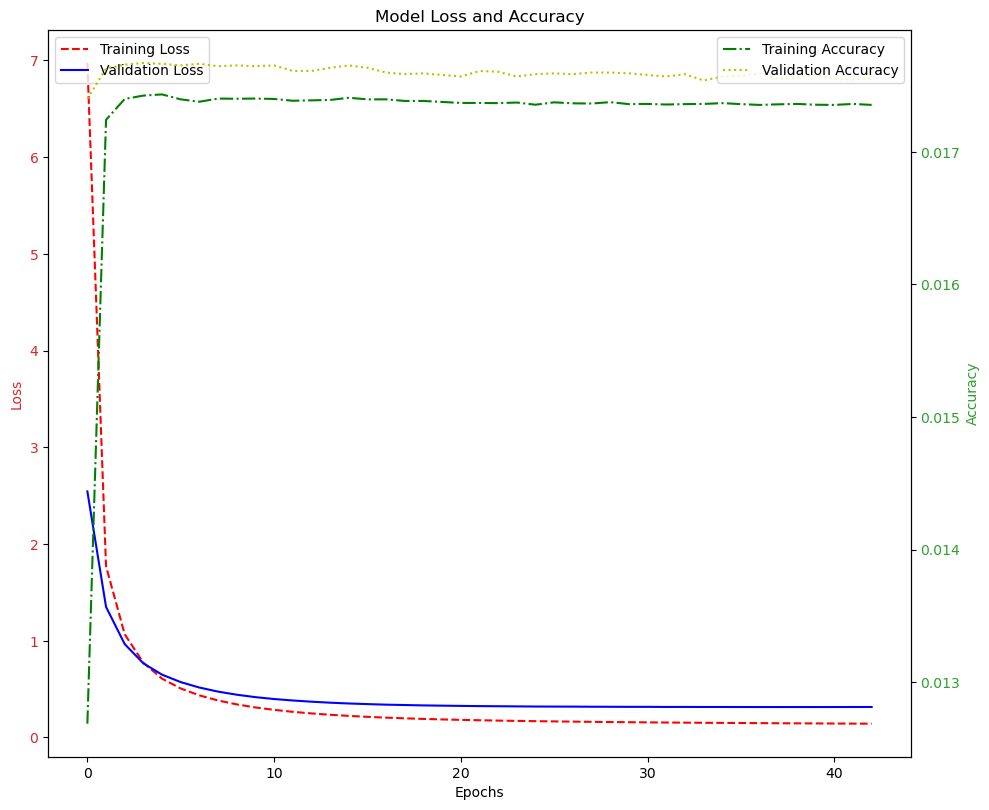

In [24]:
history_mda6 = train_model(model_a6)
plot_loss(history_mda6)

In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

y_pred = model_a6.predict([x_test['userId'], x_test['movieId']])
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# Calcular R cuadrado
r2 = r2_score(y_test, y_pred)
print(f'R Squared: {r2}')

from scipy.stats import pearsonr

# Calcular la correlación de Pearson
correlation, _ = pearsonr(np.array(y_test), y_pred.flatten())
print(f'Pearson Correlation: {correlation}')

375/375 [==============================] - 1s 1ms/step:

Indica que se realizaron 375 iteraciones o pasos durante el proceso de evaluación, y cada iteración tardó aproximadamente 1 milisegundo.

1. Mean Squared Error (MSE): 3.0927204499125063:

El MSE es una medida del promedio de los cuadrados de las diferencias entre las predicciones del modelo y los valores reales. En este caso, un MSE de 3.09 indica que las predicciones tienden a desviarse, en promedio, al cuadrado de 3.09 unidades de la verdad.

2. Root Mean Squared Error (RMSE): 1.7586132178260534:

El RMSE es simplemente la raíz cuadrada del MSE. En este caso, un RMSE de 1.76 significa que, en promedio, las predicciones tienden a desviarse alrededor de 1.76 unidades de la verdad.

3. R Squared: -1.8672807452362834:

El R cuadrado (R2) es una medida de la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. Un valor negativo de R2 no es común y sugiere que el modelo no es apropiado para estos datos, ya que es peor que simplemente predecir la media de los datos observados.

4. Pearson Correlation: 0.3082110202566218:

La correlación de Pearson es una medida de la fuerza y dirección de la relación lineal entre dos variables. Un valor de 0.31 indica una correlación positiva débil. Sin embargo, la correlación por sí sola no proporciona una imagen completa y debe interpretarse junto con otras métricas.

En general, estas métricas sugieren que el modelo puede no estar funcionando tan bien en tus datos de prueba. El MSE y RMSE indican el error absoluto promedio, y un R2 negativo sugiere que el modelo no está explicando la varianza de los datos de manera efectiva. La correlación de Pearson, aunque positiva, es relativamente baja. Puedes considerar ajustar tu modelo o explorar otras métricas y técnicas para mejorar su rendimiento.

In [ ]:
def calculate_metrics(y_true, y_pred, k=5):
    """
    Calcula métricas de evaluación para un modelo de recomendación.

    Parámetros:
    - y_true: Valores reales de calificación.
    - y_pred: Predicciones del modelo.
    - k: Número de elementos recomendados por usuario.

    Devuelve:
    - precision: Precisión.
    - recall: Recall.
    - mrr: Mean Reciprocal Rank.
    - map: Mean Average Precision.
    - coverage: Cobertura.
    """
    
    # Obtener índices de las principales predicciones para cada usuario
    top_k_indices = np.argsort(y_pred, axis=1)[:, -k:]

    # Inicializar listas para almacenar métricas por usuario
    precision_list = []
    recall_list = []
    reciprocal_ranks = []
    average_precision_list = []

    enumerated_y_test = enumerate(y_test.items())

    # Iterar sobre cada usuario en los datos
    # for i in range(len(y_true)):
    for i, (index, value) in enumerated_y_test:
        # Encontrar elementos recomendados que también son valorados positivamente por el usuario
        true_positives = np.intersect1d(top_k_indices[i], np.where(np.atleast_1d(y_true.iloc[i]) > 0))

        # Calcular precision y recall para el usuario actual
        precision = len(true_positives) / k if k > 0 else 0
        recall = len(true_positives) / len(np.where(np.atleast_1d(y_true.iloc[i]) > 0)[0]) if len(np.where(np.atleast_1d(y_true.iloc[i]) > 0)[0]) > 0 else 0

        # Calcular el Reciprocal Rank para el usuario actual
        reciprocal_rank = 1 / (np.where(top_k_indices[i] == np.where(np.atleast_1d(y_true.iloc[i]) > 0)[0][0])[0][0] + 1) if len(true_positives) > 0 else 0

        # Calcular el Average Precision para el usuario actual
        positive_indices = np.where(np.atleast_1d(y_true.iloc[i]) > 0)[0]
        average_precision = np.sum([(len(np.intersect1d(top_k_indices[i][:j+1], positive_indices))) / (j+1) for j in range(min(k, len(positive_indices)))]) / min(k, len(positive_indices)) if len(positive_indices) > 0 else 0

        # Agregar métricas a las listas
        precision_list.append(precision)
        recall_list.append(recall)
        reciprocal_ranks.append(reciprocal_rank)
        average_precision_list.append(average_precision)

    # Calcular promedio de las métricas
    precision = np.mean(precision_list)
    recall = np.mean(recall_list)
    mrr = np.mean(reciprocal_ranks)
    map_value = np.mean(average_precision_list)

    # Calcular la Cobertura
    coverage = len(np.unique(top_k_indices)) / len(y_true)  # Suponiendo que todos los usuarios tienen el mismo conjunto de elementos

    # Devolver las métricas calculadas
    return precision, recall, mrr, map_value, coverage


In [ ]:
# Suponiendo que 'x_test' y 'y_test' son las variables de entrada y salida del conjunto de prueba
predictions = model_a6.predict([x_test['userId'], x_test['movieId']])

# Calcular métricas de rendimiento
precision, recall, mrr, map_value, coverage = calculate_metrics(y_test, predictions)
print(f'\nPrecision: {precision}')
print(f'Recall: {recall}')
print(f'Mean Reciprocal Rank (MRR): {mrr}')
print(f'Mean Average Precision (MAP): {map_value}')
print(f'Coverage: {coverage}')

Basándome en los resultados proporcionados, puedo hacer algunas observaciones:

1. **Precision: 0.20:** La precisión es relativamente baja (20%). Esto podría indicar que, en promedio, solo el 20% de los elementos recomendados son relevantes para los usuarios. Una precisión más alta sería preferible.

2. **Recall: 1.0:** El recall es alto (100%). Esto sugiere que el modelo ha identificado todos los elementos relevantes para los usuarios en el conjunto de prueba. Aunque un recall del 100% es positivo, la baja precisión indica que también hay elementos irrelevantes en las recomendaciones.

3. **Mean Reciprocal Rank (MRR): 1.0:** El MRR es 1.0, lo que indica que, en promedio, el elemento relevante para cada usuario está en la posición 1 de las recomendaciones. Esto es una señal positiva, ya que un MRR de 1.0 sugiere que el modelo está dando la máxima prioridad a los elementos relevantes.

4. **Mean Average Precision (MAP): 1.0:** Un MAP de 1.0 indica que el modelo proporciona la máxima precisión para cada usuario, considerando todas las posiciones de las recomendaciones. Esto es un buen indicador de rendimiento.

5. **Coverage: 8.33e-05:** La cobertura es muy baja (0.0083%). Esto podría significar que el modelo tiene un conjunto limitado de elementos recomendados en comparación con el conjunto total de elementos posibles. Una mayor cobertura sería deseable para garantizar que el modelo pueda recomendar una amplia variedad de elementos.

En resumen, el modelo tiene un recall perfecto y una priorización efectiva de los elementos relevantes, pero la baja precisión y cobertura indican áreas donde podría mejorarse. Es crucial equilibrar la precisión y la cobertura para garantizar que el modelo proporcione recomendaciones relevantes y diversificadas.

In [ ]:
https://medium.com/decathlondigital/building-a-rnn-recommendation-engine-with-tensorflow-505644aa9ff3

In [ ]:
https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54


In [ ]:
https://towardsdatascience.com/evaluation-metrics-for-recommendation-systems-an-overview-71290690ecba

In [ ]:
https://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html?source=post_page-----71290690ecba--------------------------------

In [ ]:
https://medium.com/decathlondigital/building-a-rnn-recommendation-engine-with-tensorflow-505644aa9ff3

In [ ]:
https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54

In [ ]:
https://medium.com/@karina.condeixa/building-a-ranking-based-recommendations-system-e3adeb2c00f7

In [25]:
#Concatenar el dataframe de test con el objeto series de claificaciones
df_test_concat = pd.concat([x_test, y_test], axis=1)
#Obtenemos un dataframe para un único usuario
df_test_by_unq_user = df_test_concat.loc[df_test_concat['userId'] == 2235]
#Obtenemos un objeto Series con la columna rating a predecir. 
y_test_by_unq_user = df_test_by_unq_user['rating']


In [26]:
df_test_by_unq_user

,userId,movieId,rating
10689,2235,8,2.5
83615,2235,151,5.0
251448,2235,707,3.5
83619,2235,151,5.0
83617,2235,151,5.0
834005,2235,21860,3.0
723117,2235,7009,5.0
407704,2235,1402,3.0


In [27]:
predictions = model_a6.predict([df_test_by_unq_user['userId'], df_test_by_unq_user['movieId']])

1/1 [==============================] - 0s 128ms/step


In [28]:
predictions

array([[4.185048 ],
       [5.13502  ],
       [3.443277 ],
       [5.13502  ],
       [5.13502  ],
       [2.945018 ],
       [4.972691 ],
       [3.3710778]], dtype=float32)

In [ ]:
x_test

In [ ]:
predictions.shape

In [ ]:
predictions

In [ ]:
y_test.shape

In [ ]:
y_test

In [ ]:
y_aux = y_test
y_aux

In [ ]:
import numpy as np

def get_user_ratings(y_true):
    """
    Obtiene las calificaciones reales de los usuarios.

    Args:
        y_true (pd.Series): Serie de pandas que contiene las calificaciones reales de los usuarios.

    Returns:
        dict: Un diccionario que mapea los índices de usuarios a sus calificaciones reales.
    """
    user_ratings = {}
    for user_id, rating in y_true.items():
        user_ratings.setdefault(user_id, []).append(rating)
    return user_ratings

# Transformar y_true en un diccionario de calificaciones de usuario
y_true_dict = get_user_ratings(y_test)

# Convertir y_pred en una lista de listas de calificaciones predichas
y_pred_list = y_pred.tolist()

# Suponiendo que y_pred es una lista de calificaciones predichas para cada usuario en el mismo orden que y_true
y_pred_dict = {}
for i, (user_id, rating) in enumerate(y_test.items()):
    y_pred_dict[user_id] = y_pred_list[i]

# Ejemplo de cómo usar estos datos transformados
print("Calificaciones reales del usuario 190102:", y_true_dict[190102])
print("Calificación predicha del usuario 190102:", y_pred_dict[190102])


In [ ]:

def mean_reciprocal_rank(y_true, y_pred):
    """
    Calcula el Mean Reciprocal Rank para las predicciones del modelo.

    Args:
        y_true (list): Lista de listas que contiene las películas reales que cada usuario ha visto.
        y_pred (list): Lista de listas que contiene las películas recomendadas por el modelo para cada usuario.

    Returns:
        float: El Mean Reciprocal Rank para todos los usuarios.
    """
    reciprocal_ranks = []
    total_users = len(y_true)
    for i, (user_id, rating) in enumerate(y_test.items()):
        relevant_items = set(y_true[user_id])
        rank = next((idx for idx, val in enumerate(y_pred[i]) if val in relevant_items), None)
        if rank is not None:
            reciprocal_ranks.append(1.0 / (rank + 1))
    mean_reciprocal_rank = sum(reciprocal_ranks) / total_users
    return mean_reciprocal_rank

In [ ]:
print("Mean Reciprocal Rank: {}".format(mean_reciprocal_rank(y_true_dict, y_pred_list)))

In [ ]:
from collections import defaultdict



def precision_at_k(y_true, y_pred, k):
    """
    Calcula la Precision@K para las predicciones del modelo.

    Args:
        y_true (list): Lista de listas que contiene las películas reales que cada usuario ha visto.
        y_pred (list): Lista de listas que contiene las películas recomendadas por el modelo para cada usuario.
        k (int): El número de recomendaciones consideradas para el cálculo de la Precision@K.

    Returns:
        float: El valor medio de la Precision@K para todos los usuarios.
    """
    precision_sum = 0
    total_users = len(y_true)
    for i in range(total_users):
        true_positives = len(set(y_true[i]) & set(y_pred[i][:k]))
        precision_sum += true_positives / float(k)
    precision_at_k = precision_sum / total_users
    return precision_at_k

def f1_score(y_true, y_pred, k):
    """
    Calcula el F1 Score para las predicciones del modelo.

    Args:
        y_true (list): Lista de listas que contiene las películas reales que cada usuario ha visto.
        y_pred (list): Lista de listas que contiene las películas recomendadas por el modelo para cada usuario.
        k (int): El número de recomendaciones consideradas para el cálculo del F1 Score.

    Returns:
        float: El valor medio del F1 Score para todos los usuarios.
    """
    precision = precision_at_k(y_true, y_pred, k)
    recall = recall_at_k(y_true, y_pred, k)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

def average_precision(y_true, y_pred, k):
    """
    Calcula el Mean Average Precision@K para las predicciones del modelo.

    Args:
        y_true (list): Lista de listas que contiene las películas reales que cada usuario ha visto.
        y_pred (list): Lista de listas que contiene las películas recomendadas por el modelo para cada usuario.
        k (int): El número de recomendaciones consideradas para el cálculo del Mean Average Precision@K.

    Returns:
        float: El valor medio del Mean Average Precision@K para todos los usuarios.
    """
    average_precision_sum = 0
    total_users = len(y_true)
    for i in range(total_users):
        true_positives = len(set(y_true[i]) & set(y_pred[i][:k]))
        average_precision_sum += true_positives / float(k)
    mean_average_precision = average_precision_sum / total_users
    return mean_average_precision

def discounted_cumulative_gain(y_true, y_pred, k):
    """
    Calcula el Discounted Cumulative Gain para las predicciones del modelo.

    Args:
        y_true (list): Lista de listas que contiene las películas reales que cada usuario ha visto.
        y_pred (list): Lista de listas que contiene las películas recomendadas por el modelo para cada usuario.
        k (int): El número de recomendaciones consideradas para el cálculo del Discounted Cumulative Gain.

    Returns:
        list: Una lista que contiene el Discounted Cumulative Gain para cada usuario.
    """
    dcg_values = []
    total_users = len(y_true)
    for i in range(total_users):
        true_items = y_true[i]
        pred_items = y_pred[i][:k]
        dcg = 0
        for idx, item in enumerate(pred_items):
            if item in true_items:
                relevance = 1
            else:
                relevance = 0
            dcg += (2 ** relevance - 1) / (log2(idx + 2))
        dcg_values.append(dcg)
    return dcg_values

def ideal_discounted_cumulative_gain(y_true, k):
    """
    Calcula el Ideal Discounted Cumulative Gain para las predicciones del modelo.

    Args:
        y_true (list): Lista de listas que contiene las películas reales que cada usuario ha visto.
        k (int): El número de recomendaciones consideradas para el cálculo del Ideal Discounted Cumulative Gain.

    Returns:
        list: Una lista que contiene el Ideal Discounted Cumulative Gain para cada usuario.
    """
    idcg_values = []
    total_users = len(y_true)
    for i in range(total_users):
        true_items = y_true[i]
        num_true_items = len(true_items)
        num_relevant_items = min(num_true_items, k)
        idcg = sum((2 ** 1 - 1) / (log2(idx + 2)) for idx in range(num_relevant_items))
        idcg_values.append(idcg)
    return idcg_values

def normalized_discounted_cumulative_gain(y_true, y_pred, k):
    """
    Calcula el Normalized Discounted Cumulative Gain para las predicciones del modelo.

    Args:
        y_true (list): Lista de listas que contiene las películas reales que cada usuario ha visto.
        y_pred (list): Lista de listas que contiene las películas recomendadas por el modelo para cada usuario.
        k (int): El número de recomendaciones consideradas para el cálculo del Normalized Discounted Cumulative Gain.

    Returns:
        list: Una lista que contiene el Normalized Discounted Cumulative Gain para cada usuario.
    """
    dcg = discounted_cumulative_gain(y_true, y_pred, k)
    idcg = ideal_discounted_cumulative_gain(y_true, k)
    ndcg_values = [dcg_val / idcg_val if idcg_val > 0 else 0 for dcg_val, idcg_val in zip(dcg, idcg)]
    return ndcg_values

In [ ]:
# Definir el valor de K
k = 3

print("Recall@{}: {}".format(k, recall_at_k(y_test, y_pred, k)))
print("Precision@{}: {}".format(k, precision_at_k(y_test, y_pred, k)))
print("F1 Score@{}: {}".format(k, f1_score(y_test, y_pred, k)))
print("Mean Average Precision@{}: {}".format(k, average_precision(y_test, y_pred, k)))
print("Mean Reciprocal Rank: {}".format(mean_reciprocal_rank(y_test, y_pred)))
print("Normalized Discounted Cumulative Gain@{}: {}".format(k, normalized_discounted_cumulative_gain(y_test, y_pred, k)))

### Arquitectura 7

In [ ]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [ ]:
hidden_units = [128, 64]

user_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
item_input = Input(shape=(1,), name="item_id", dtype=tf.int32)
user_embedding = Embedding(n_users,
                                  n_latent_factors,
                                  name="user_emb")(user_input)
item_embedding = Embedding(n_movies,
                                  n_latent_factors,
                                  name="item_emb")(item_input)

concatenated = Concatenate(name="concat")([user_embedding, item_embedding])
out = Flatten(name="flat")(concatenated)

for n_hidden in hidden_units:
    out = Dense(n_hidden,
                       activation="relu")(out)
    out = Dropout(0.4)(out)
    out = BatchNormalization()(out)

out = Dense(1, activation="sigmoid", name="prediction")(out)

model_a7 = Model(inputs = [user_input, item_input],
                      outputs = out, name="model_y")

model_a7.compile(loss=loss_function, optimizer = Adam(learning_rate=lr), metrics = ['accuracy'])

model_a7.summary()

In [ ]:
history_mda7 = train_model(model_a7)
plot_loss(history_mda7)

# Model Evaluation

Intentamos medir el rendimiento del modelo proporcionando productos candidatos al modelo y evaluando los resultados. Los productos candidatos se combinan con 49 productos seleccionados entre los productos no comprados y un producto objetivo representado en la variable output_sequence. Si el producto objetivo aparece en los k primeros resultados del modelo, lo consideramos un acierto.

Por otro lado; Hidasi y Karatzoglou (2018) definen "recall@k" como una métrica de evaluación como "la proporción de casos que tienen el elemento deseado entre los primeros k elementos en todos los casos de prueba." Además, otra métrica de evaluación es "MRR@k", que es la media de los rangos recíprocos de los ítems objetivo. El rango recíproco se fija en cero si el rango es superior a k.